In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [106]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

/anaconda3/envs/dsbase/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [107]:
import sys
sys.path.append('../src/main')

In [108]:
from dsbase.models.regression.LightGradientBoostingRegressionDSBase import LightGradientBoostingRegressionDSBaseModel

/anaconda3/envs/dsbase/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Test Data Loading 

In [3]:
test_df = pd.read_csv('../datasets/predict-sales/test.csv')
items_df = pd.read_csv('../datasets/predict-sales/items.csv')

In [4]:
items_df.drop(labels=['item_name'], inplace=True, axis=1)

In [5]:
test_df_enriched = test_df.merge(right=items_df, on='item_id', how='left')

In [6]:
def concatAttr(x):
    return (str(x[0]) + '-' + str(x[1]))

In [7]:
test_df_enriched['ID_pair'] = test_df_enriched[['shop_id','item_id']].apply(concatAttr, axis=1)
test_df_enriched['ID_CAT_pair'] = test_df_enriched[['shop_id','item_category_id']].apply(concatAttr, axis=1)

In [8]:
test_df_enriched.head()

,ID,shop_id,item_id,item_category_id,ID_pair,ID_CAT_pair
0,0,5,5037,19,5-5037,5-19
1,1,5,5320,55,5-5320,5-55
2,2,5,5233,19,5-5233,5-19
3,3,5,5232,23,5-5232,5-23
4,4,5,5268,20,5-5268,5-20


# Sales Direct Load

In [9]:
sales_df = pd.read_csv('../datasets/predict-sales/sales_train_enriched.csv')

In [10]:
sales_df.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

In [11]:
sales_df.head()

,index,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID_pair,item_category_id,ID_CAT_pair
0,0,0,59,22154,999.0,1.0,59-22154,37,59-37
1,3270,0,24,22154,999.0,1.0,24-22154,37,24-37
2,17081,0,27,22154,999.0,1.0,27-22154,37,27-37
3,25918,0,25,22154,999.0,1.0,25-22154,37,25-37
4,25919,0,25,22154,999.0,1.0,25-22154,37,25-37



# Preparing Data with FeatureTools (evaluation)

In [12]:
import featuretools as ft

Let's evaluate the FT process 

In [13]:
months = [30,31,32]

In [14]:
sales_months_df = sales_df[sales_df['date_block_num'].isin(months)]

In [15]:
sales_months_df.drop(labels=['date_block_num','item_id','shop_id','item_category_id'], inplace=True, axis=1)

In [16]:
sales_months_df.head()

,index,item_price,item_cnt_day,ID_pair,ID_CAT_pair
36,2721275,299.0,1.0,6-22154,6-37
37,2736888,299.0,1.0,42-22154,42-37
38,2736905,299.0,1.0,42-22154,42-37
39,2745357,299.0,1.0,57-22154,57-37
40,2767578,299.0,1.0,35-22154,35-37


## EntitySet Processing (Recommended by FeatureTools)

We will calculate 3 tables that we must join later:

### Categories Aggregation 

In [17]:
def getCatAgg(sales_months_df):
    es = ft.EntitySet(id="prediction_sales")
    es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_months_df, index='index')
    es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='idsCat',
                         index='ID_CAT_pair')
    feature_matrix_idsCat, feature_defs_idsCat = ft.dfs(entityset=es, target_entity='idsCat')
    idsCat = feature_matrix_idsCat.reset_index()
    idsCat_agg = idsCat[['ID_CAT_pair','SUM(sales.item_cnt_day)',
                     'MEAN(sales.item_cnt_day)','MEAN(sales.item_price)',
                     'STD(sales.item_cnt_day)','STD(sales.item_price)',
                     'MAX(sales.item_cnt_day)','MAX(sales.item_price)',
                     'MIN(sales.item_cnt_day)','MIN(sales.item_price)',
                     'SKEW(sales.item_cnt_day)','SKEW(sales.item_price)'
                    ]]
    idsCat_agg.columns = ['ID_CAT_pair','sum_shop_cat_sales',
                      'mean_shop_cat_day','mean_shop_cat_item_price',
                      'std_shop_cat_day','std_shop_cat_item_price',
                      'max_shop_cat_day','max_shop_cat_item_price',
                      'min_shop_cat_day','min_shop_cat_item_price',
                      'skew_shop_cat_day','skew_shop_cat_item_price',
                     ]
    return idsCat_agg

In [18]:
idsCat = getCatAgg(sales_months_df)

In [19]:
idsCat.head()

,ID_CAT_pair,sum_shop_cat_sales,mean_shop_cat_day,mean_shop_cat_item_price,std_shop_cat_day,std_shop_cat_item_price,max_shop_cat_day,max_shop_cat_item_price,min_shop_cat_day,min_shop_cat_item_price,skew_shop_cat_day,skew_shop_cat_item_price
0,10-12,3.0,1.000000,26864.690000,0.000000,2730.841343,1.0,29665.00,1.0,24209.07,0.000000,0.237757
1,10-15,6.0,1.000000,6249.801667,0.000000,3881.008534,1.0,12433.44,1.0,1762.67,0.000000,0.682262
2,10-19,83.0,1.077922,1250.331169,0.480302,780.123847,5.0,3066.34,1.0,25.89,7.542533,0.757169
3,10-2,4.0,1.000000,2026.675000,0.000000,496.668334,1.0,2396.65,1.0,1322.00,0.000000,-1.439296
4,10-20,131.0,1.297030,2536.979901,0.964827,1106.198396,9.0,8058.02,1.0,26.93,5.774914,1.317792


In [20]:
idsCat.shape

(1977, 12)

In [21]:
idsCat['ID_CAT_pair'].nunique()

1977

### Item Aggregation

In [22]:
def getItemAgg(sales_months_df):
    es = ft.EntitySet(id="prediction_sales")
    es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_months_df, index='index')
    es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='ids',
                         index='ID_pair',
                         additional_variables=['ID_CAT_pair'])
    feature_matrix_ids, feature_defs_ids = ft.dfs(entityset=es, target_entity='ids')
    ids = feature_matrix_ids.reset_index()
    return ids

In [23]:
ids = getItemAgg(sales_months_df)

In [24]:
ids.head()

,ID_pair,ID_CAT_pair,SUM(sales.item_price),SUM(sales.item_cnt_day),STD(sales.item_price),STD(sales.item_cnt_day),MAX(sales.item_price),MAX(sales.item_cnt_day),SKEW(sales.item_price),SKEW(sales.item_cnt_day),MIN(sales.item_price),MIN(sales.item_cnt_day),MEAN(sales.item_price),MEAN(sales.item_cnt_day),COUNT(sales)
0,10-10042,10-40,315.00,1.0,NaN,NaN,315.0,1.0,NaN,NaN,315.00,1.0,315.000,1.0,1
1,10-10115,10-40,295.00,1.0,NaN,NaN,295.0,1.0,NaN,NaN,295.00,1.0,295.000,1.0,1
2,10-10131,10-55,279.37,2.0,7.516545,0.0,145.0,1.0,NaN,NaN,134.37,1.0,139.685,1.0,2
3,10-10132,10-55,145.00,1.0,NaN,NaN,145.0,1.0,NaN,NaN,145.00,1.0,145.000,1.0,1
4,10-10158,10-55,265.00,1.0,NaN,NaN,265.0,1.0,NaN,NaN,265.00,1.0,265.000,1.0,1


In [25]:
ids.shape

(65588, 15)

In [26]:
ids['ID_pair'].nunique()

65588

### Join of the 3 previous tables  for evaluation

In [64]:
def joinEvaluationThreeParts(test, ids, idsCat):
    df = test.merge(right=ids,on='ID_pair',how='left')
    
    # Adapting ID_CAT_pair
    df.drop(labels=['ID_CAT_pair_y'], inplace=True, axis=1)
    columns = np.array(df.columns)
    columns[5]='ID_CAT_pair'
    df.columns = columns
    
    df_completed = df.merge(right=idsCat,on='ID_CAT_pair',how='left')
    
    df_completed_sorted = df_completed[['ID_pair','SUM(sales.item_price)','SUM(sales.item_cnt_day)','STD(sales.item_price)','STD(sales.item_cnt_day)','MAX(sales.item_price)','MAX(sales.item_cnt_day)','SKEW(sales.item_price)','SKEW(sales.item_cnt_day)','MIN(sales.item_price)','MIN(sales.item_cnt_day)','MEAN(sales.item_price)','MEAN(sales.item_cnt_day)','COUNT(sales)','sum_shop_cat_sales','mean_shop_cat_day','mean_shop_cat_item_price','std_shop_cat_day','std_shop_cat_item_price','max_shop_cat_day','max_shop_cat_item_price','min_shop_cat_day','min_shop_cat_item_price','skew_shop_cat_day','skew_shop_cat_item_price','ID_CAT_pair']]
    df_completed_sorted.drop(labels=['ID_CAT_pair'], inplace=True, axis=1)
    return df_completed_sorted

In [72]:
joinTest = joinEvaluationThreeParts(test_df_enriched, ids, idsCat)

In [73]:
joinTest.head()

,ID_pair,SUM(sales.item_price),SUM(sales.item_cnt_day),STD(sales.item_price),STD(sales.item_cnt_day),MAX(sales.item_price),MAX(sales.item_cnt_day),SKEW(sales.item_price),SKEW(sales.item_cnt_day),MIN(sales.item_price),...,mean_shop_cat_day,mean_shop_cat_item_price,std_shop_cat_day,std_shop_cat_item_price,max_shop_cat_day,max_shop_cat_item_price,min_shop_cat_day,min_shop_cat_item_price,skew_shop_cat_day,skew_shop_cat_item_price
0,5-5037,5246.0,5.0,410.609395,0.0,1499.0,1.0,0.608579,0.0,749.0,...,1.095070,1305.676862,0.539706,712.697606,9.0,3999.0,1.0,248.0,11.618093,1.239153
1,5-5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.002941,299.982353,0.054233,100.243331,2.0,749.0,1.0,28.0,18.439089,1.326220
2,5-5233,3596.0,4.0,346.410162,0.0,1199.0,1.0,0.000000,0.0,599.0,...,1.095070,1305.676862,0.539706,712.697606,9.0,3999.0,1.0,248.0,11.618093,1.239153
3,5-5232,599.0,1.0,NaN,NaN,599.0,1.0,NaN,NaN,599.0,...,1.089385,1326.955559,0.427758,723.512939,5.0,3999.0,1.0,298.0,6.615576,1.291817
4,5-5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.210000,2511.301725,1.114500,1372.620776,14.0,9999.0,-1.0,299.0,8.684221,1.110642


# Generating the DataSet 

In [77]:
slots = sales_df['date_block_num'].nunique()

In [80]:
slot_seq = np.arange(1,slots)

In [76]:
def generateFeaturesForEvaluation(sales_df, months_feature, test_df):
    print('evaluation features window:',months_feature)
    sales_months_df = sales_df[sales_df['date_block_num'].isin(months_feature)]
    sales_months_df.drop(labels=['date_block_num','shop_id','item_id','item_category_id'], inplace=True, axis=1)
    
    idsCat = getCatAgg(sales_months_df)
    ids = getItemAgg(sales_months_df)
    
    joined = joinEvaluationThreeParts(test_df, ids, idsCat)
    
    # Insert the slot component for correlation purposes
    joined['slot'] = joined['COUNT(sales)'].apply(lambda x: months_feature[-1])
    return joined

# Ensemble/Stacking Evaluation Processing

### Dataset Test

In [85]:
dstest = generateFeaturesForEvaluation(sales_df, slot_seq[-3:], test_df_enriched)

evaluation features window: [31 32 33]


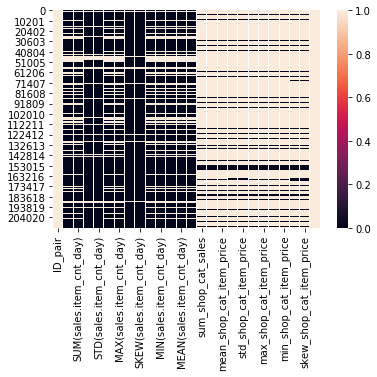

In [86]:
sns.heatmap(~dstest.isna())

## Ensemble Processing

In [88]:
windows = [3,6,12,18,25,32]

In [96]:
def processFold(i):
    months = slot_seq[-windows[i-1]:]
    fold_df = generateFeaturesForEvaluation(sales_df, months, test_df_enriched)
    
    #sns.heatmap(~fold_df.isna())
    # TODO cleaning and imputing data
    
    # TODO Prediction in model fold[index]
        
    return 

### Fold 1

evaluation features window: [31 32 33]


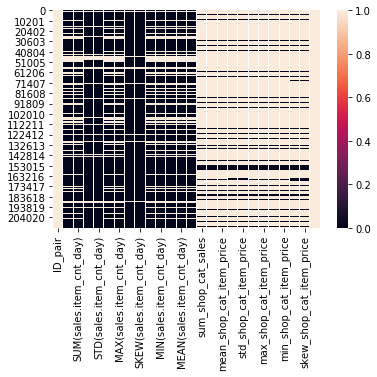

In [97]:
result1 = processFold(1)

### Fold 2

evaluation features window: [28 29 30 31 32 33]


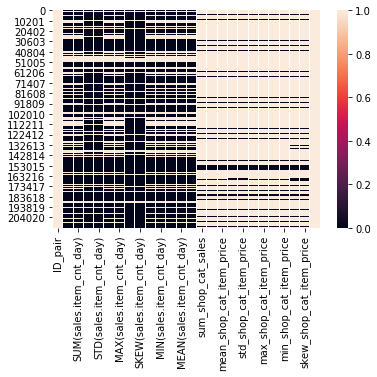

In [98]:
result2 = processFold(2)

### Fold 3

evaluation features window: [22 23 24 25 26 27 28 29 30 31 32 33]


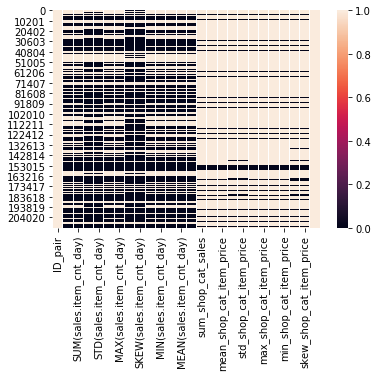

In [99]:
result3 = processFold(3)

### Fold 4

evaluation features window: [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


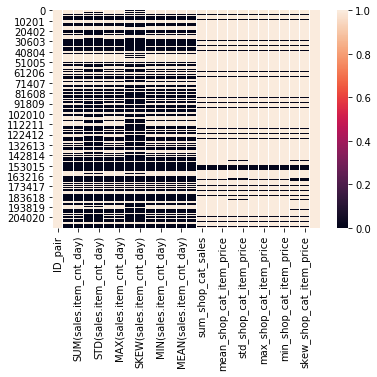

In [100]:
result4 = processFold(4)

### Fold 5

evaluation features window: [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33]


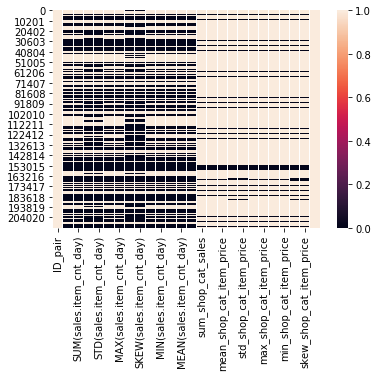

In [101]:
result5 = processFold(5)

### Fold 6

evaluation features window: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33]


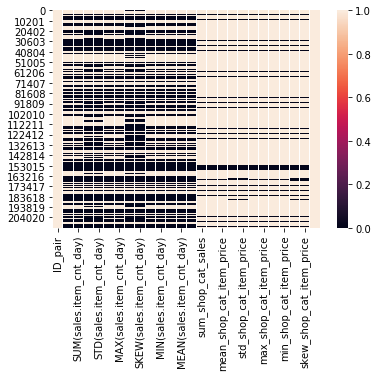

In [102]:
result6 = processFold(6)

## Stacking Dataset 

In [ ]:
# TODO

# End of Case! 